# Analyse Geschäfte
ToDo:
* Wer reicht am meisten ein?
* Wer wird am meisten abgelehnt?
* Welches Geschlecht legt mehr ein?
* Werden Frauen mehr abgelehnt?

In [36]:
from pathlib import Path
import pandas as pd
import datetime
import utils
import json
#pd.options.plotting.backend = "plotly"

In [37]:
df_raw = pd.read_csv(Path('../export/geschaefte.csv'))

# Only Members
df_raw = df_raw[df_raw.erstunterzeichneristkantonsrat == True]

# To Datetime
df_raw['start'] = pd.to_datetime(df_raw['start'])

# Calculate Amtsjahr (Amtsjahr 2020 = 1.5.2020 - 30.4.2021)
df_raw['year'] = df_raw['start'].dt.year
df_raw['month'] = df_raw['start'].dt.month
df_raw['session'] = df_raw.apply(lambda row: row['year'] if row['month'] > 5 else row['year'] - 1, axis=1)

# Concat Name for convenience reasons
df_raw['_name'] = df_raw.apply(lambda row: "%s %s" % (row['erstunterzeichnervorname'], row['erstunterzeichnername']), axis = 1)

# Load Kantonsrats-member-history
with open(Path('../export/mitglieder.json'), encoding='utf-8') as f:
    kantonsrat = json.load(f)

# Typecast
utils.kantonsrat_to_datetime(kantonsrat)

## Vorstösse pro Jahr

d:\Entwicklung\_Projects\nzz_zh_kantonsrat_genderstudy\env\lib\site-packages\pandas\plotting\_matplotlib\core.py:633: UserWarning: The handle <BarContainer object of 22 artists> has a label of '_name' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


<AxesSubplot:xlabel='session'>

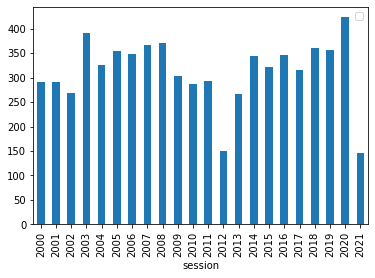

In [27]:
df_raw.groupby('session').agg({'_name': 'count'}).plot.bar()

## Wer reicht pro Jahr am meisten ein?

<AxesSubplot:xlabel='session'>

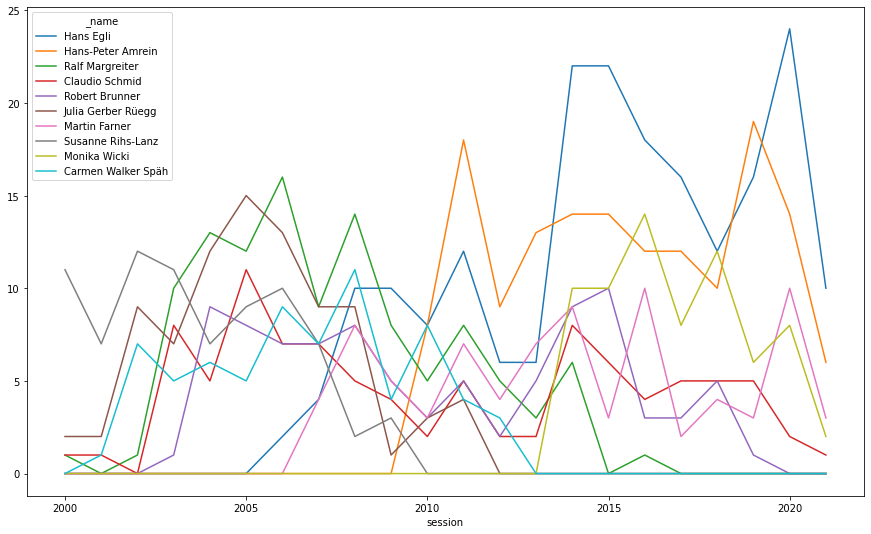

In [28]:
df = pd.pivot_table(df_raw, index=['_name'], columns='session', values='start', aggfunc='count').fillna(0)

df['s'] = df.sum(axis=1)

df = df.sort_values('s', ascending=False).head(10)
df.drop(columns='s', inplace=True)
#df = df[df.s >= 10]

df.T.plot.line(figsize=(15, 9))

## Men vs Women, plain numbers

<AxesSubplot:xlabel='session'>

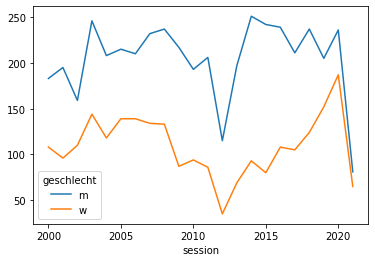

In [29]:
pd.pivot_table(df_raw, index='session', columns='geschlecht', values='_name', aggfunc='count').plot()

## Men vs Women per capita

<AxesSubplot:xlabel='session'>

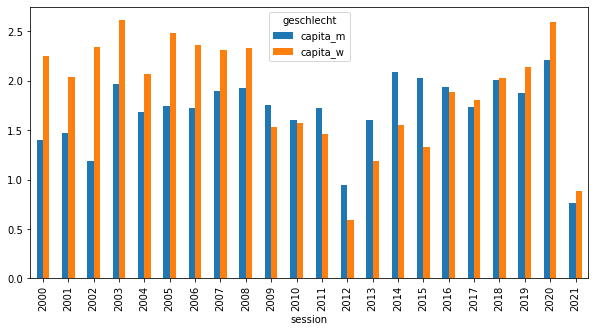

In [78]:
# Calculate, how many m and w where in Kantonsrat at that time. Reference day: 1. 7. 20XX
dtx = []
for year in range(df_raw['session'].min(), df_raw['session'].max() + 1):

    dt = datetime.datetime(year, 7, 1)
    df = utils.kantonsrat_as_dataframe(kantonsrat, dt)
    df['year'] = year
    dtx.append(df)

df = pd.concat(dtx)

# Pivot by year
df = pd.pivot_table(df, index='year', columns='geschlecht', values='name', aggfunc='count')
df.rename(columns={'m': 'count_m', 'w': 'count_w'}, inplace=True)

df_pivot = pd.pivot_table(df_raw, index='session', columns='geschlecht', values='_name', aggfunc='count')

# Join both DFs
df_pivot = df_pivot.join(df)

# Calc per Capita
df_pivot['capita_m'] = round(df_pivot['m'] / df_pivot['count_m'], 2)
df_pivot['capita_w'] = round(df_pivot['w'] / df_pivot['count_w'], 2)

df_pivot[['capita_m', 'capita_w']].plot.bar(figsize=(10, 5))


## a) Wessen Vorstösse werden am meisten abgelehnt?

In [124]:
# Only Erledigt
df = df_raw[df_raw.status == 'Erledigt']

# Only with certain result
#df = df[df.letzterschritttyp.isin(['Ablehnung', 'Abschreibung', 'Rückzug', 'Zustimmung', 'Rückweisung', 'Ablehnung - Nicht vorläufig unterstützt'])]

df = pd.pivot_table(df, index='_name', columns='letzterschritttyp', values='krnr', aggfunc='count').fillna(0)

# Combine Ablehnung + Ablehnung - Nicht vorläufig unterstützt
df['Ablehnung'] = df['Ablehnung'] + df['Ablehnung - Nicht vorläufig unterstützt']
df.drop(columns='Ablehnung - Nicht vorläufig unterstützt', inplace=True)

# Calculate Percentage
df = df.mul(100).div(df.sum(axis=1), axis=0).round(1)

df = df.sort_values('Ablehnung', ascending=False)

df.head()

letzterschritttyp,Ablehnung,Abschreibung,Antrag Kommission,Antrag Regierungsrat,Antrag auf Diskussion,Antwort GL KR,Antwort Regierungsrat,Antwort VK Gerichte,Diskutiert,Eingereicht,Erledigt,Nichteintreten,Rückweisung,Rückzug,Stellungnahme Geschäftsleitung,Stellungnahme Regierungsrat,Wegfall,Zustimmung,Überweisung an Regierungsrat,Überweisung an die Geschäftsleitung
_name,,,,,,,,,,,,,,,,,,,,
Franz Cahannes,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Paul Stopper,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Martin Kull,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Valentin Landmann,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Walter Isliker,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
# Lets calculate only "Ablehnung" and get absolute numbers as well

# Only Erledigt
df = df_raw[df_raw.status == 'Erledigt']

# pivot
df = pd.pivot_table(df, index=['_name', 'geschlecht'], columns='letzterschritttyp', values='krnr', aggfunc='count').fillna(0)

# Combine Ablehnung + Ablehnung - Nicht vorläufig unterstützt
df['Ablehnung'] = df['Ablehnung'] + df['Ablehnung - Nicht vorläufig unterstützt']
df.drop(columns='Ablehnung - Nicht vorläufig unterstützt', inplace=True)

# sum
df['sum'] = df.sum(axis=1)

df = df[['Ablehnung', 'sum']]

# Percentage
df['%'] = round(df['Ablehnung'] * 100 / df['sum'], 1)

# Remove less than 5
df = df[df['sum'] >= 5]

df = df.sort_values('%', ascending=False)

df.head(10)

,letzterschritttyp,Ablehnung,sum,%
_name,geschlecht,,,
Esther Hildebrand,w,9.0,14.0,64.3
Andreas Hauri,m,8.0,14.0,57.1
Beni Schwarzenbach,m,4.0,8.0,50.0
Stefan Hunger,m,5.0,11.0,45.5
Stefan Dollenmeier,m,12.0,29.0,41.4
Ronald Alder,m,2.0,5.0,40.0
Peter Stirnemann,m,2.0,5.0,40.0
Regula Götsch Neukom,w,4.0,10.0,40.0
Cäcilia Hänni-Etter,w,2.0,5.0,40.0


## b) The same for Gender

In [132]:
df_b = df.copy().reset_index()

df_b = df_b.groupby('geschlecht').agg({'Ablehnung': 'sum', 'sum': 'sum', '_name': 'count'})

df_b['%'] = round(df_b['Ablehnung'] * 100 / df_b['sum'], 1)

df_b.head()


letzterschritttyp,Ablehnung,sum,_name,%
geschlecht,,,,
m,462.0,3960.0,200,11.7
w,291.0,2036.0,112,14.3
